## Arima Exercise

In [79]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette='inferno')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()

In [10]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

**Task:** Print the top 5 rows.

In [11]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**Task:** Create the function called `plot_timeseries(df)`.

In [241]:
def plot_timeseries(df, title, kind=None):
    fig,ax = plt.subplots(figsize=(15,10))
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('No. of Passengers')
    if kind:
        ax.plot(df, label='observations', kind=kind)
    else:
        ax.plot(df, label='observations')
    plt.legend()
    plt.show()

**Task:** Plot the time series from above.

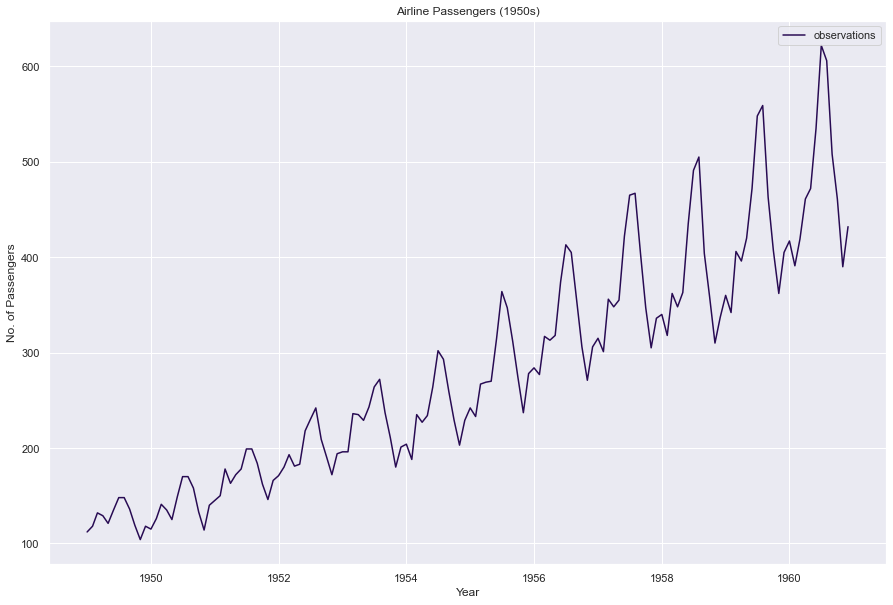

In [242]:
plot_timeseries(df, 'Airline Passengers (1950s)')

**Task:** Compute the rolling mean and the rolling std with an appropriate window size.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

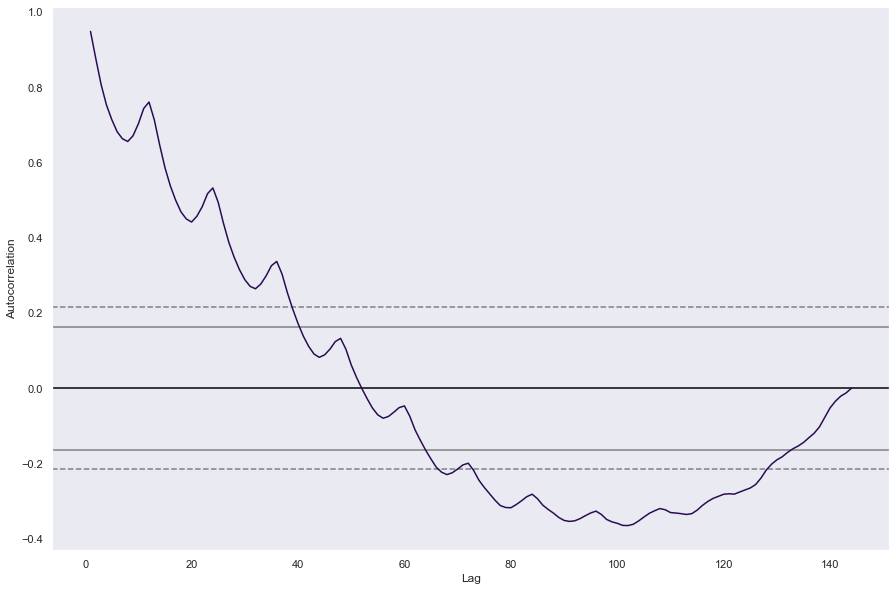

In [243]:
fig,ax = plt.subplots(figsize=(15,10))
autocorrelation_plot(df, ax)

**Task:** Plot the two time series:
- with rolling mean 
- with rolling std

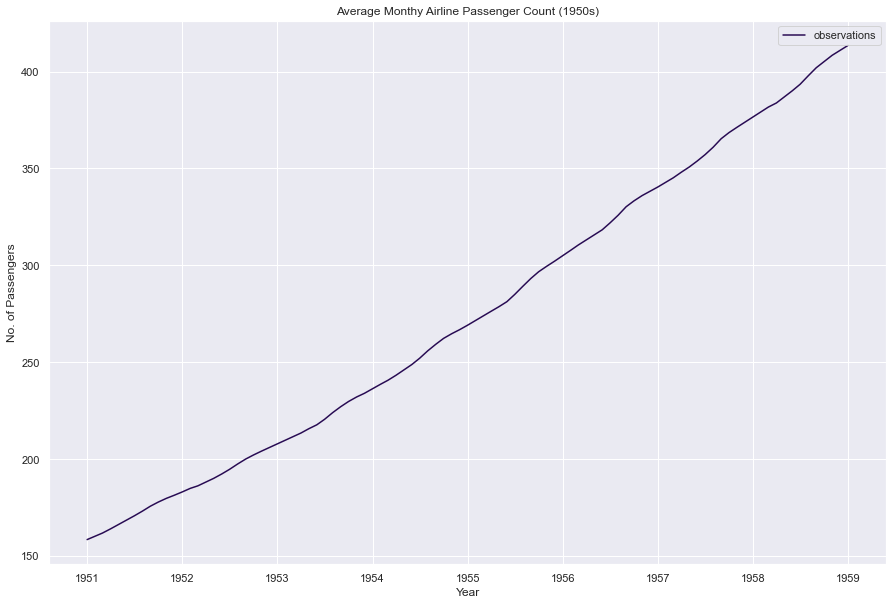

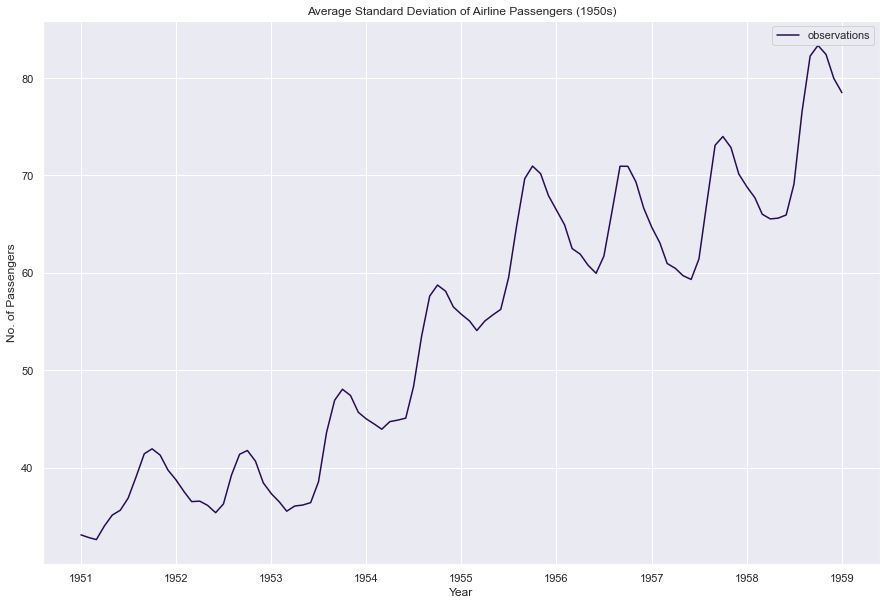

In [244]:
plot_timeseries(df.rolling(window=48, center=True).mean(), 'Average Monthy Airline Passenger Count (1950s)')
plot_timeseries(df.rolling(window=48, center=True).std(), 'Average Standard Deviation of Airline Passengers (1950s)')

**Task:** Test the stationarity of all the time series

In [245]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
    results = adfuller(df)
    print(f't-test: {results[0]}')
    print(f'p-value: {results[1]}')
    print(f'critical values:')
    for key,value in results[4].items():
        print(f'{key} : {value}')

test_stationarity(df)

t-test: 0.8153688792060507
p-value: 0.991880243437641
critical values:
1% : -3.4816817173418295
5% : -2.8840418343195267
10% : -2.578770059171598


**Task:** Perform a log transformation on the original time series. 

In [246]:
dflog = df.apply(lambda x: np.log(x))


**Task:** Plot the transformed time series.

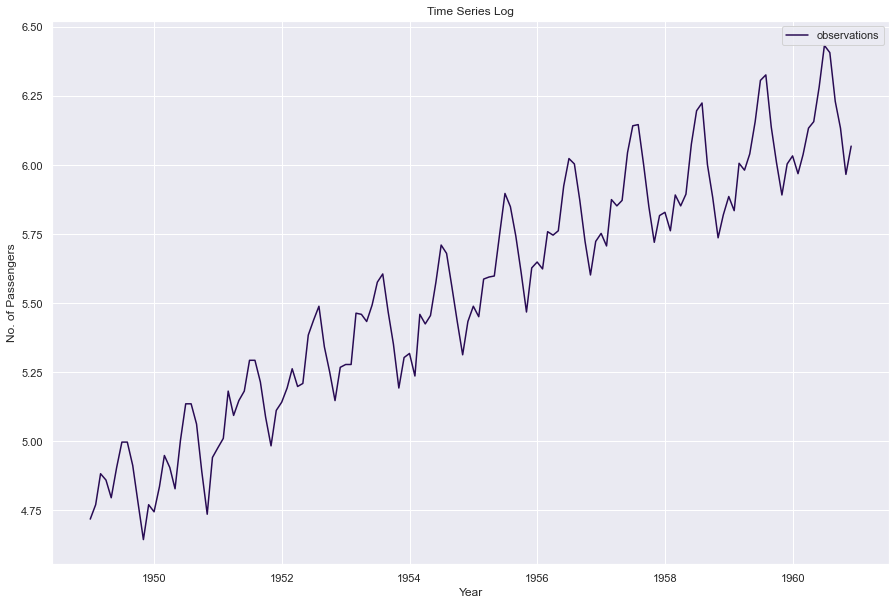

In [247]:
plot_timeseries(dflog, 'Time Series Log')

**Task:** Test the stationarity of the transformed time series. If it isn't stationary, try a different transformation technique. 

In [248]:
test_stationarity(dflog)

t-test: -1.7170170891069674
p-value: 0.422366774770388
critical values:
1% : -3.4816817173418295
5% : -2.8840418343195267
10% : -2.578770059171598


**Task:** Use the stationary time series and find the optimal `(p, d, q)` parameters of ARIMA model.

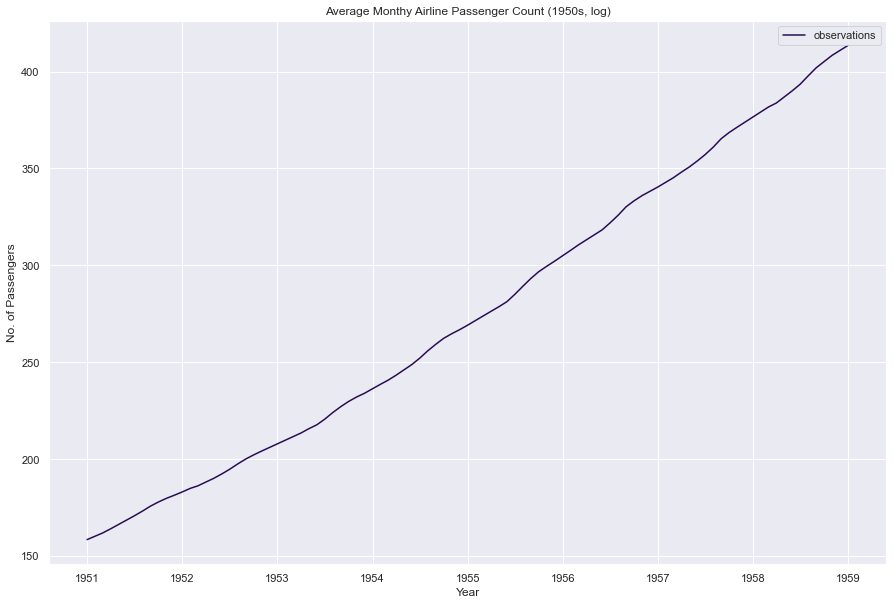

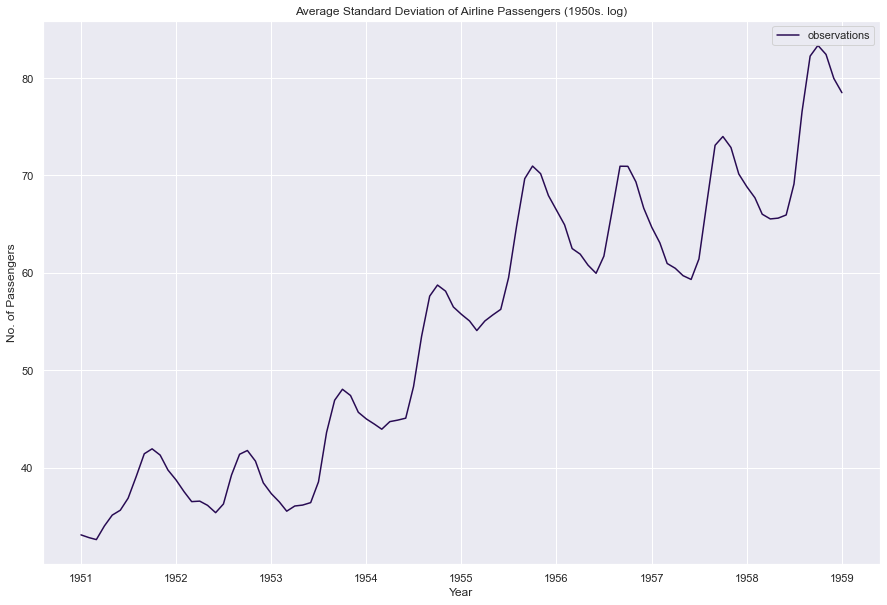

In [249]:
plot_timeseries(df.rolling(window=48, center=True).mean(), 'Average Monthy Airline Passenger Count (1950s, log)')
plot_timeseries(df.rolling(window=48, center=True).std(), 'Average Standard Deviation of Airline Passengers (1950s. log)')

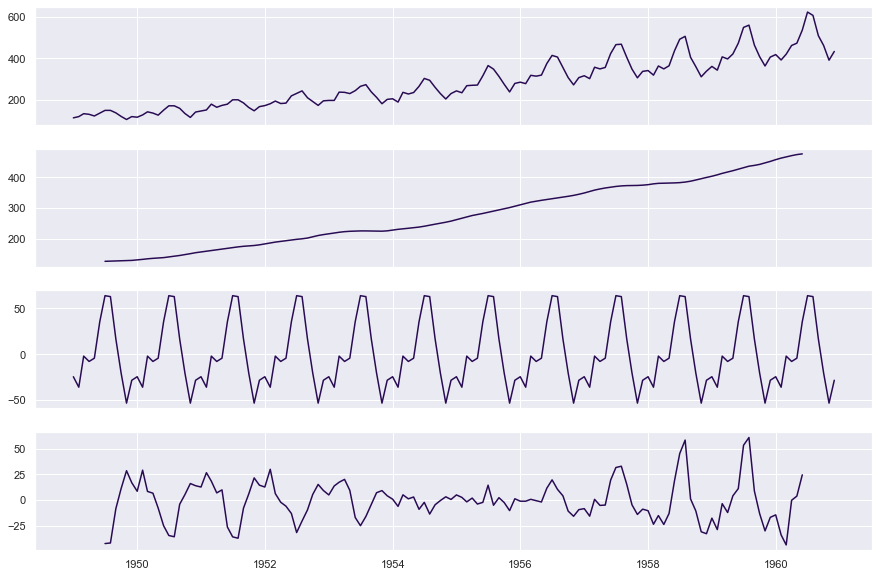

In [250]:
decomposed = seasonal_decompose(df)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,10), sharex=True)
ax1.plot(decomposed.observed, label='observed')
ax2.plot(decomposed.trend, label='trend')
ax3.plot(decomposed.seasonal, label='seasonal')
ax4.plot(decomposed.resid,  label='residual')
plt.show()

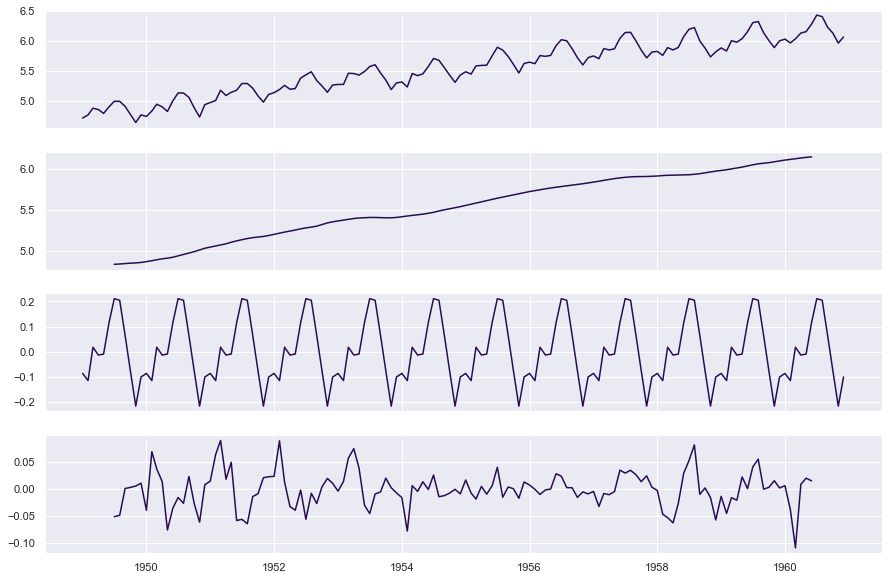

In [251]:
decomposedlog = seasonal_decompose(dflog)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,10), sharex=True)
ax1.plot(decomposedlog.observed, label='observed')
ax2.plot(decomposedlog.trend, label='trend')
ax3.plot(decomposedlog.seasonal, label='seasonal')
ax4.plot(decomposedlog.resid,  label='residual')
plt.show()

In [307]:
dftrans = dflog - dflog.shift(-2)

In [308]:
test_stationarity(dftrans.dropna())

t-test: -3.1679073752887317
p-value: 0.021919114564039603
critical values:
1% : -3.4816817173418295
5% : -2.8840418343195267
10% : -2.578770059171598


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


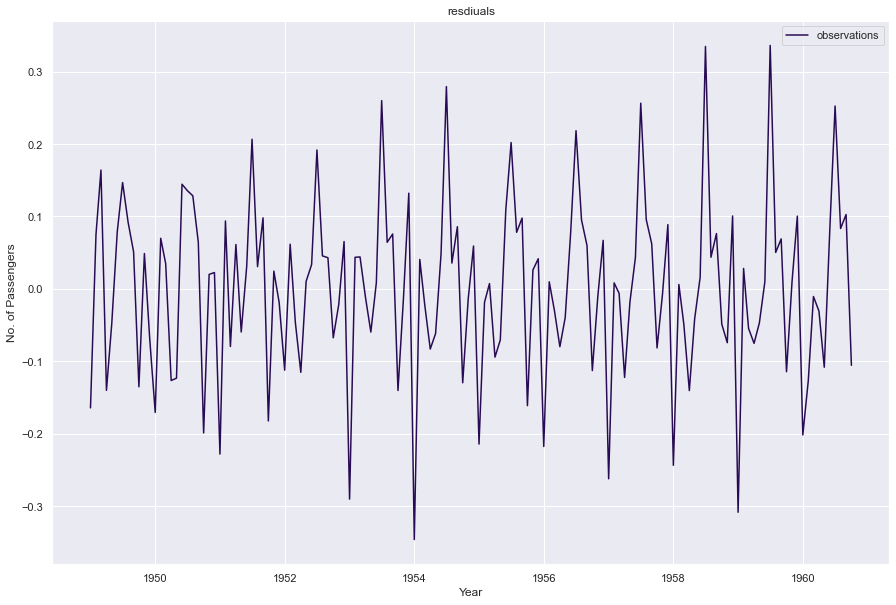

<AxesSubplot:ylabel='Density'>

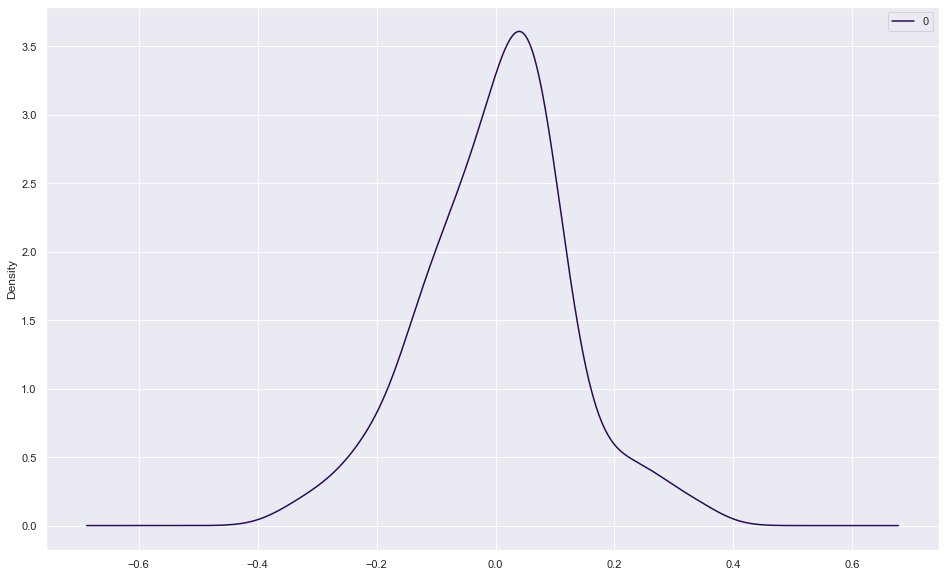

In [309]:
model = ARIMA(dftrans, order=(5,1,0))
model_fit = model.fit()

model_fit.summary()
plot_timeseries(model_fit.resid, 'resdiuals')

fig,ax = plt.subplots(figsize=(16,10))
pd.DataFrame(model_fit.resid).plot(ax=ax, kind='kde')

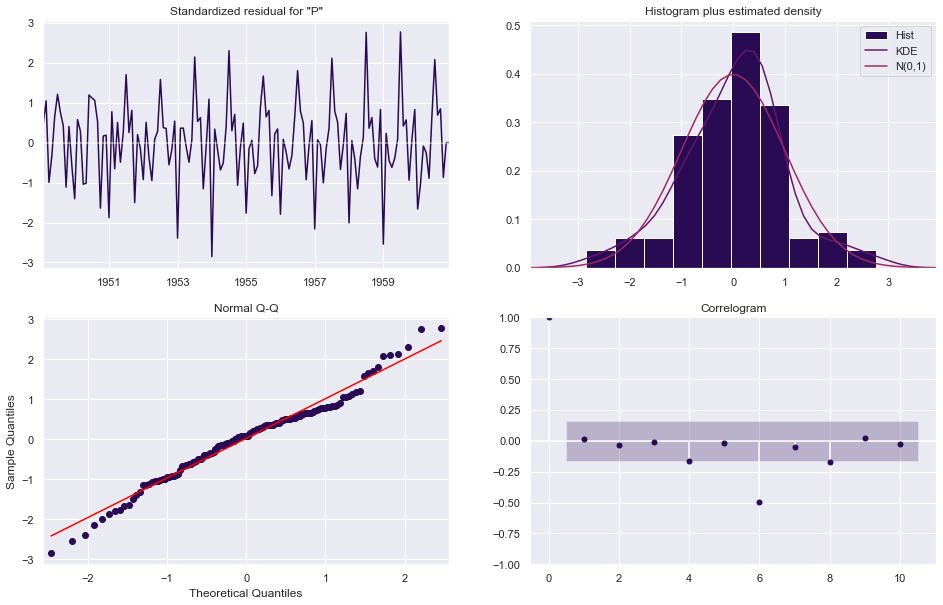

In [310]:
model_fit.plot_diagnostics(figsize=(16,10))
plt.show()

**Task:** Plot the predictions (not transformed to the original scale).

In [349]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split data
x = dftrans.dropna().values
xtrain, xtest = train_test_split(x, test_size=0.33, shuffle=False)

# build history & store predictions
history = [x for x in xtrain]
predictions = list()

# walk forward validation
for t in range(len(xtest)):
    # fit data
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit()
    
    # predict forecast
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    obs = xtest[t]
    history.append(obs)
    
    # print(f'predicted = {yhat}, expected = {obs}')
    
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(xtest, predictions))
print(f'RMSE: {rmse}')

RMSE: 0.1352981363596397


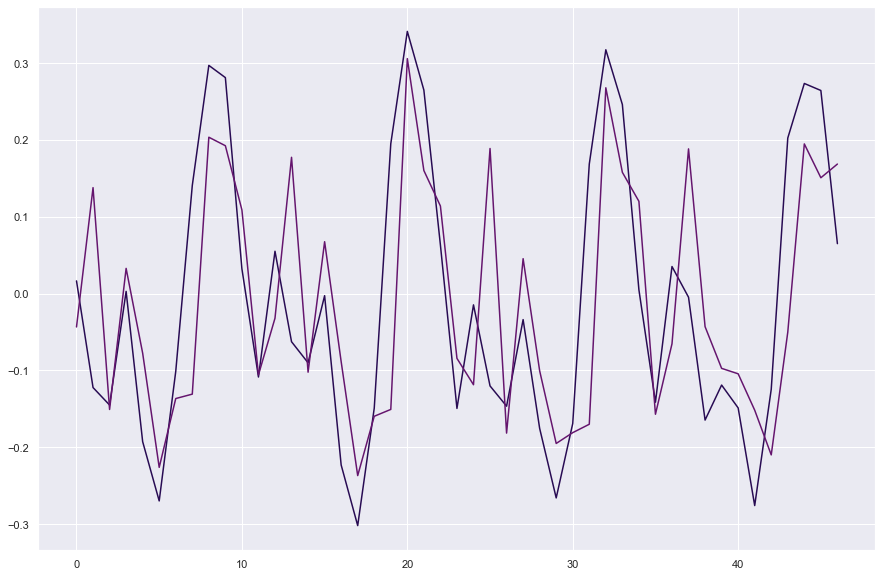

In [350]:
# plot forecasts against actual outcomes
fig,ax = plt.subplots(figsize=(15,10))
plt.plot(xtest)
plt.plot(predictions)
plt.show()

**Task:** Plot the predictions (transformed to the original scale).

In [351]:
# predtrans = pd.Series(predictions)

In [361]:
predlog = pd.Series([predictions[i] + dflog.mean() for i in range(47)])
pred = predlog.apply(lambda x: np.e**x)

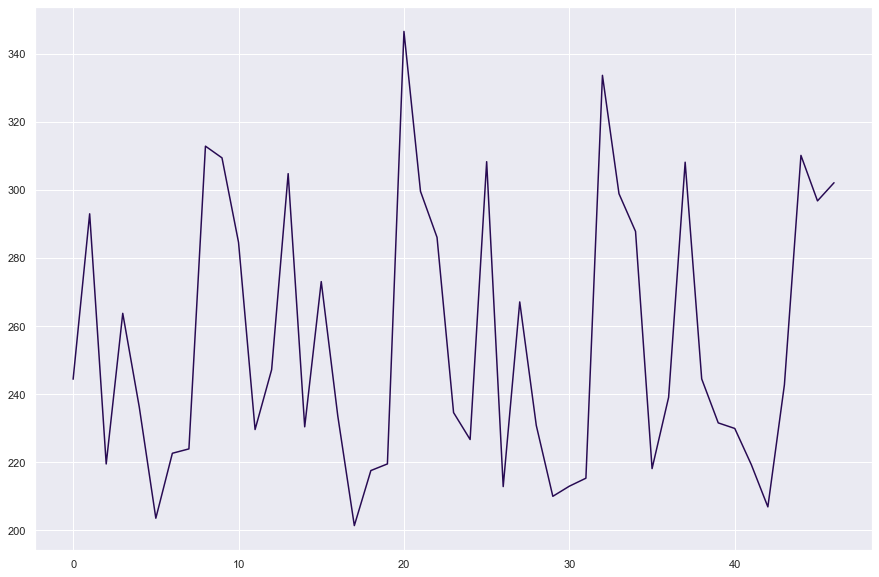

In [365]:
fig,ax = plt.subplots(figsize=(15,10))
plt.plot(pred)
plt.show()

**Task:** Plot the predictions for the next 10 years. How accurate do you think your model is predicting that far in the future? 

In [368]:
for t in range(10):
    # fit data
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit()
    
    # predict forecast
    output = model_fit.forecast()
    print(output)
    yhat = output[0]
    predictions.append(yhat)

    history.append(yhat)
    
    # print(f'predicted = {yhat}, expected = {obs}')

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/statsmodels/base/data.py:668: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''